In [23]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import featuretools as ft

In [24]:
# Read meta data
meta = pd.read_csv('/Users/t.wang/Desktop/Dissertation/Python/input/meta_open.csv', 
                   index_col='uid', parse_dates=['dataend','datastart'], dayfirst=True)#The data will be messed up withou specifying dayfirst


# Read energy data
temporal = pd.read_csv('/Users/t.wang/Desktop/Dissertation/Python/input/temp_open_utc_complete.csv', 
                   index_col='timestamp', parse_dates=True).tz_localize('utc')

# Read energy data for each given buildingname
single_building = 'Office_Benthe'
single_timezone = meta.T[single_building].timezone
startdate = meta.T[single_building].datastart
enddate = meta.T[single_building].dataend
single_building_energy = temporal[single_building].tz_convert(single_timezone).truncate(before = startdate, 
                                                            after = enddate)#.fillna(method='bfill').fillna(method='ffill')

# single_building_energy = single_building_energy.dropna()
# print(startdate)
# print(single_building_energy)
# single_building_energy, some nan data


# Get weather data for given building
weatherfile_name = meta.T[single_building].newweatherfilename
weather_data = pd.read_csv(os.path.join('/Users/t.wang/Desktop/Dissertation/Python/input/',
                                        weatherfile_name),index_col='timestamp', parse_dates=True, na_values='-9999')
weather_data = weather_data.tz_localize(single_timezone, ambiguous = 'infer')
weather_point = ['TemperatureC', 'Humidity','Dew PointC','Sea Level PressurehPa', 
                 'Wind Direction','Conditions','WindDirDegrees'] #Whatever weather features you want, put in the list
weather_point_list=[]
for point in weather_point:
    point_data = weather_data[[point]]
    weather_point_list.append(point_data)
    all_weather_point = pd.concat(weather_point_list,axis=1) #axis=1, rowwise concat
    all_weather_point = all_weather_point[~all_weather_point.index.duplicated()]#To get rid of duplicated index
    all_weather_point = all_weather_point.reindex(pd.DatetimeIndex(start = all_weather_point.index[0], 
                                                                   periods=len(single_building_energy), 
                                                                   freq='H')).fillna(method='ffill').fillna(method='bfill')
# print(single_building_energy.shape, all_weather_point.shape)
    
# Get schedule data for given building
schedule_name = meta.T[single_building].annualschedule
schedule_data = pd.read_csv(os.path.join('/Users/t.wang/Desktop/Dissertation/Python/input/',
                                        schedule_name),index_col=0, header=None, parse_dates=True)
schedule_data = schedule_data.tz_localize(single_timezone, ambiguous = 'infer')
schedule_data.columns = ['seasonal']
schedule_data = schedule_data.reindex(pd.DatetimeIndex(start = schedule_data.index[0], periods=len(single_building_energy), 
                                                       freq='H')).fillna(method='ffill').fillna(method='bfill')
# print(schedule_data.shape)

# Create TimeSeriesSplit
# get the month number for splitting
months = np.array(single_building_energy.index.month.unique())
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)
train_test_list = []
for train_index, test_index in tscv.split(months):
    months_train, months_test = months[train_index], months[test_index]
    train_test_list.append([months_train, months_test])
# Add the 'every-four-month' version, 5th month is duplicated in Clayton's notebook
train_test_list.append([np.concatenate([months[0:3],months[4:7],months[8:11]]),
                                     np.array([months[3],months[7],months[11]])])
for train_index, test_index in train_test_list: #get rid of the 'array', extract the numeric months from the list
#     print(train_index, test_index)
    months_for_train = train_index
    months_for_test = test_index
# print(months_for_train,months_for_test)
    


In [25]:
# One table approach
single_building_energy_n = single_building_energy[single_building_energy.index.month.isin(months_for_train)]
#     single_building_energy_n.to_csv('/Users/t.wang/Desktop/' + 'single_building_energy_n' +'.csv', index=False)

all_weather_point_n = all_weather_point[all_weather_point.index.month.isin(months_for_train)]
# all_weather_point_n.to_csv('/Users/t.wang/Desktop/' + 'all_weather_point_n' +'.csv', index=True)

schedule_data_n = schedule_data[schedule_data.index.month.isin(months_for_train)]
#     schedule_data_n.to_csv('/Users/t.wang/Desktop/' + 'schedule_data_n' +'.csv', index=False)


#     print(single_building_energy_n.shape, all_weather_point_n.shape, schedule_data_n.shape)
#rename _n is required, otherwise the function will run on top of incomplete dataset after one running(after traindata, testdata disappeared)

features = pd.merge(pd.DataFrame(single_building_energy_n.index.tz_localize(None)), 
                    schedule_data_n.reset_index(drop=True), right_index=True, left_index=True)#remove the time zone information
features = pd.concat([features, all_weather_point_n.reset_index(drop=True)], axis=1) #.reset_index(drop=True) to get rid of the time index, otherwise two sets data will stratify
features = features.fillna(method='ffill').fillna(method='bfill')
print(features)
# features = np.array(features)
labels = single_building_energy_n.values

'''separated table approach
single_building_energy_n = single_building_energy[single_building_energy.index.month.isin(months_for_train)]
#     single_building_energy_n.to_csv('/Users/t.wang/Desktop/' + 'single_building_energy_n' +'.csv', index=False)

all_weather_point_n = all_weather_point[all_weather_point.index.month.isin(months_for_train)]
all_weather_point_n = pd.concat([pd.DataFrame(single_building_energy_n.index.tz_localize(None)),#remove the time zone information 
                                 all_weather_point_n.reset_index(drop=True)], axis=1)#use energy time index
# all_weather_point_n.to_csv('/Users/t.wang/Desktop/' + 'all_weather_point_n' +'.csv', index=False)

schedule_data_n = schedule_data[schedule_data.index.month.isin(months_for_train)]
schedule_data_n = pd.concat([pd.DataFrame(single_building_energy_n.index.tz_localize(None)), #remove the time zone information 
                                schedule_data_n.reset_index(drop=True)], axis=1)#use energy time index
#     schedule_data_n.to_csv('/Users/t.wang/Desktop/' + 'schedule_data_n' +'.csv', index=False)


# print(pd.DataFrame(single_building_energy_n.index))
# print(pd.DataFrame(single_building_energy_n.index.tz_localize(None)))
# all_weather_point_n
# schedule_data_n'''

               timestamp seasonal  TemperatureC  Humidity  Dew PointC  \
0    2012-01-01 00:00:00  Holiday           3.0      70.0        -2.0   
1    2012-01-01 01:00:00  Holiday           3.0      65.0        -3.0   
2    2012-01-01 02:00:00  Holiday           3.0      65.0        -3.0   
3    2012-01-01 03:00:00  Holiday           2.0      65.0        -4.0   
4    2012-01-01 04:00:00  Holiday           1.0      65.0        -5.0   
5    2012-01-01 05:00:00  Holiday          -1.0      75.0        -5.0   
6    2012-01-01 06:00:00  Holiday          -1.0      75.0        -5.0   
7    2012-01-01 07:00:00  Holiday          -1.0      75.0        -5.0   
8    2012-01-01 08:00:00  Holiday          -1.0      75.0        -5.0   
9    2012-01-01 09:00:00  Holiday           0.0      75.0        -4.0   
10   2012-01-01 10:00:00  Holiday           2.0      60.0        -5.0   
11   2012-01-01 11:00:00  Holiday           4.0      39.0        -9.0   
12   2012-01-01 12:00:00  Holiday           6.0    

"separated table approach\nsingle_building_energy_n = single_building_energy[single_building_energy.index.month.isin(months_for_train)]\n#     single_building_energy_n.to_csv('/Users/t.wang/Desktop/' + 'single_building_energy_n' +'.csv', index=False)\n\nall_weather_point_n = all_weather_point[all_weather_point.index.month.isin(months_for_train)]\nall_weather_point_n = pd.concat([pd.DataFrame(single_building_energy_n.index.tz_localize(None)),#remove the time zone information \n                                 all_weather_point_n.reset_index(drop=True)], axis=1)#use energy time index\n# all_weather_point_n.to_csv('/Users/t.wang/Desktop/' + 'all_weather_point_n' +'.csv', index=False)\n\nschedule_data_n = schedule_data[schedule_data.index.month.isin(months_for_train)]\nschedule_data_n = pd.concat([pd.DataFrame(single_building_energy_n.index.tz_localize(None)), #remove the time zone information \n                                schedule_data_n.reset_index(drop=True)], axis=1)#use energy tim

# FeatureTools

FeatureTools involves two means of generating new features, namely Aggreagation and Transformation.

Aggreagation performs across multiple tables, requiring 'one to many' or 'parent to child' relationship. For instance, 'client' table is parent whereas the 'loan' table is child in that one client has multiple loans. It is operative to find the Min of loans per client.

Transformation operates on one table, the relationship is not required. For instance, extracting temporal information, log the temperature in a weather table belongs to transformation means.

Since we simply have parallel data, schedule and weather information, it is not possible to do aggreagation (the 'one to many' relationship does not exist), lets try transformation only!!


In [26]:
es = ft.EntitySet(id = 'buildingFeatures') #create Entity set

In [27]:
# create an entity from feature table, unique index is created
es = es.entity_from_dataframe(entity_id='featureData', dataframe=features,
                              make_index=True, index='feature_id', time_index = 'timestamp')

In [28]:
es

Entityset: buildingFeatures
  Entities:
    featureData [Rows: 6576, Columns: 10]
  Relationships:
    No relationships

In [29]:
es['featureData']
# although featuretools will automatically infer the data type of each column in an entity, 
# we can override this by passing in a dictionary of column types to the parameter variable_types .

Entity: featureData
  Variables:
    feature_id (dtype: index)
    timestamp (dtype: datetime_time_index)
    seasonal (dtype: categorical)
    TemperatureC (dtype: numeric)
    Humidity (dtype: numeric)
    Dew PointC (dtype: numeric)
    Sea Level PressurehPa (dtype: numeric)
    Wind Direction (dtype: categorical)
    Conditions (dtype: categorical)
    WindDirDegrees (dtype: numeric)
  Shape:
    (Rows: 6576, Columns: 10)

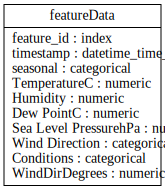

In [30]:
es.plot()

## Aggreagation, we can not do it

In [31]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

# Aggregations: operations completed across a parent-to-child (one-to-many) relationship 
# that group by the parent and calculate stats for the children. An example is 
# grouping the loan table by the client_id and finding the maximum loan amount for each client.

,name,type,description
0,num_true,aggregation,Counts the number of `True` values.
1,sum,aggregation,"Calculates the total addition, ignoring `NaN`."
2,count,aggregation,"Determines the total number of values, excluding `NaN`."
3,num_unique,aggregation,"Determines the number of distinct values, ignoring `NaN` values."
4,std,aggregation,"Computes the dispersion relative to the mean value, ignoring `NaN`."
5,skew,aggregation,Computes the extent to which a distribution differs from a normal distribution.
6,max,aggregation,"Calculates the highest value, ignoring `NaN` values."
7,time_since_last,aggregation,Calculates the time elapsed since the last datetime (in seconds).
8,avg_time_between,aggregation,Computes the average number of seconds between consecutive events.
9,time_since_first,aggregation,Calculates the time elapsed since the first datetime (in seconds).


## Transformation, try it

In [32]:
primitives[primitives['type'] == 'transform'].head(100)

# Transformations: operations done on a single table to one or more columns. 
# An example is taking the difference between two columns in one table or taking the absolute value of a column.

,name,type,description
20,not_equal,transform,Determines if values in one list are not equal to another list.
21,isin,transform,Determines whether a value is present in a provided list.
22,equal,transform,Determines if values in one list are equal to another list.
23,is_weekend,transform,Determines if a date falls on a weekend.
24,divide_numeric,transform,Element-wise division of two lists.
25,and,transform,Element-wise logical AND of two lists.
26,less_than_equal_to,transform,Determines if values in one list are less than or equal to another list.
27,month,transform,Determines the month value of a datetime.
28,cum_min,transform,Calculates the cumulative minimum.
29,multiply_numeric,transform,Element-wise multiplication of two lists.


In [33]:
# Create new features using specified primitives
features, feature_names = ft.dfs(entityset = es, target_entity = 'featureData', max_depth = 2)
#                                 ,agg_primitives = [],
#                                 trans_primitives = ['month','weekday','hour','is_weekend','divide_numeric',
#                                'and','multiply_numeric','divide_by_feature','absolute','week','subtract_numeric',
#                                'percentile'], verbose = True)
# We do not have to manually specify the feature primitives, but instead can let featuretools automatically 
# choose features for us. To do this, do not pass in any feature primitives
# or mannually select with domain knowledge

## Only timestamp is transformed.......NOT REALLY USEFUL

In [34]:
feature_names

[<Feature: seasonal>,
 <Feature: TemperatureC>,
 <Feature: Humidity>,
 <Feature: Dew PointC>,
 <Feature: Sea Level PressurehPa>,
 <Feature: Wind Direction>,
 <Feature: Conditions>,
 <Feature: WindDirDegrees>,
 <Feature: DAY(timestamp)>,
 <Feature: YEAR(timestamp)>,
 <Feature: MONTH(timestamp)>,
 <Feature: WEEKDAY(timestamp)>]

In [35]:
features

,seasonal,TemperatureC,Humidity,Dew PointC,Sea Level PressurehPa,Wind Direction,Conditions,WindDirDegrees,DAY(timestamp),YEAR(timestamp),MONTH(timestamp),WEEKDAY(timestamp)
feature_id,,,,,,,,,,,,
0,Holiday,3.0,70.0,-2.0,1019.9,NW,Clear,320.0,1,2012,1,6
1,Holiday,3.0,65.0,-3.0,1020.9,NNW,Clear,330.0,1,2012,1,6
2,Holiday,3.0,65.0,-3.0,1022.9,NNW,Clear,330.0,1,2012,1,6
3,Holiday,2.0,65.0,-4.0,1024.9,NNW,Clear,330.0,1,2012,1,6
4,Holiday,1.0,65.0,-5.0,1025.3,Calm,Clear,0.0,1,2012,1,6
5,Holiday,-1.0,75.0,-5.0,1026.3,Calm,Clear,0.0,1,2012,1,6
6,Holiday,-1.0,75.0,-5.0,1027.3,Calm,Clear,0.0,1,2012,1,6
7,Holiday,-1.0,75.0,-5.0,1028.3,Calm,Clear,0.0,1,2012,1,6
8,Holiday,-1.0,75.0,-5.0,1030.0,Calm,Clear,0.0,1,2012,1,6


In [36]:
# one hot encoding for categorical data
features_enc, feature_names_enc = ft.encode_features(features, feature_names)

In [37]:
feature_names_enc

[<Feature: seasonal = Regular>,
 <Feature: seasonal = Summer>,
 <Feature: seasonal = Holiday>,
 <Feature: seasonal = Break>,
 <Feature: seasonal is unknown>,
 <Feature: TemperatureC>,
 <Feature: Humidity>,
 <Feature: Dew PointC>,
 <Feature: Sea Level PressurehPa>,
 <Feature: Wind Direction = Calm>,
 <Feature: Wind Direction = South>,
 <Feature: Wind Direction = North>,
 <Feature: Wind Direction = SSE>,
 <Feature: Wind Direction = SSW>,
 <Feature: Wind Direction = NNW>,
 <Feature: Wind Direction = NW>,
 <Feature: Wind Direction = NNE>,
 <Feature: Wind Direction = West>,
 <Feature: Wind Direction = SE>,
 <Feature: Wind Direction is unknown>,
 <Feature: Conditions = Clear>,
 <Feature: Conditions = Overcast>,
 <Feature: Conditions = Scattered Clouds>,
 <Feature: Conditions = Mostly Cloudy>,
 <Feature: Conditions = Light Rain>,
 <Feature: Conditions = Rain>,
 <Feature: Conditions = Fog>,
 <Feature: Conditions = Light Snow>,
 <Feature: Conditions = Haze>,
 <Feature: Conditions = Light Drizzl

In [38]:
features_enc

,seasonal = Regular,seasonal = Summer,seasonal = Holiday,seasonal = Break,seasonal is unknown,TemperatureC,Humidity,Dew PointC,Sea Level PressurehPa,Wind Direction = Calm,...,MONTH(timestamp) = 2,MONTH(timestamp) is unknown,WEEKDAY(timestamp) = 1,WEEKDAY(timestamp) = 6,WEEKDAY(timestamp) = 5,WEEKDAY(timestamp) = 4,WEEKDAY(timestamp) = 3,WEEKDAY(timestamp) = 2,WEEKDAY(timestamp) = 0,WEEKDAY(timestamp) is unknown
feature_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,3.0,70.0,-2.0,1019.9,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,3.0,65.0,-3.0,1020.9,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,3.0,65.0,-3.0,1022.9,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,2.0,65.0,-4.0,1024.9,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,1.0,65.0,-5.0,1025.3,1,...,0,0,0,1,0,0,0,0,0,0
5,0,0,1,0,0,-1.0,75.0,-5.0,1026.3,1,...,0,0,0,1,0,0,0,0,0,0
6,0,0,1,0,0,-1.0,75.0,-5.0,1027.3,1,...,0,0,0,1,0,0,0,0,0,0
7,0,0,1,0,0,-1.0,75.0,-5.0,1028.3,1,...,0,0,0,1,0,0,0,0,0,0
8,0,0,1,0,0,-1.0,75.0,-5.0,1030.0,1,...,0,0,0,1,0,0,0,0,0,0


## Instead of automatically generating data, lets try to mannually specify some transformation primitives

In [39]:
features, feature_names = ft.dfs(entityset = es, target_entity = 'featureData', max_depth = 2
                                ,agg_primitives = [],
                                trans_primitives = ['month','weekday','hour','is_weekend','divide_numeric',
                               'and','multiply_numeric','divide_by_feature','absolute','week','subtract_numeric',
                               'percentile'], verbose = True)

Built 1453 features
Elapsed: 00:08 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [40]:
feature_names

[<Feature: seasonal>,
 <Feature: TemperatureC>,
 <Feature: Humidity>,
 <Feature: Dew PointC>,
 <Feature: Sea Level PressurehPa>,
 <Feature: Wind Direction>,
 <Feature: Conditions>,
 <Feature: WindDirDegrees>,
 <Feature: MONTH(timestamp)>,
 <Feature: WEEKDAY(timestamp)>,
 <Feature: HOUR(timestamp)>,
 <Feature: IS_WEEKEND(timestamp)>,
 <Feature: Humidity / Dew PointC>,
 <Feature: Sea Level PressurehPa / Dew PointC>,
 <Feature: Humidity / TemperatureC>,
 <Feature: WindDirDegrees / Dew PointC>,
 <Feature: TemperatureC / WindDirDegrees>,
 <Feature: Dew PointC / Humidity>,
 <Feature: Humidity / Sea Level PressurehPa>,
 <Feature: TemperatureC / Humidity>,
 <Feature: Dew PointC / WindDirDegrees>,
 <Feature: Sea Level PressurehPa / Humidity>,
 <Feature: Sea Level PressurehPa / WindDirDegrees>,
 <Feature: WindDirDegrees / Humidity>,
 <Feature: TemperatureC / Sea Level PressurehPa>,
 <Feature: TemperatureC / Dew PointC>,
 <Feature: Humidity / WindDirDegrees>,
 <Feature: Dew PointC / Sea Level Pre

In [41]:
features

,seasonal,TemperatureC,Humidity,Dew PointC,Sea Level PressurehPa,Wind Direction,Conditions,WindDirDegrees,MONTH(timestamp),WEEKDAY(timestamp),...,PERCENTILE(Sea Level PressurehPa - TemperatureC),PERCENTILE(Dew PointC - Sea Level PressurehPa),PERCENTILE(Dew PointC - TemperatureC),PERCENTILE(TemperatureC - WindDirDegrees),PERCENTILE(Dew PointC - Humidity),PERCENTILE(Humidity - WindDirDegrees),PERCENTILE(Humidity - TemperatureC),PERCENTILE(Sea Level PressurehPa - WindDirDegrees),PERCENTILE(Humidity - Sea Level PressurehPa),PERCENTILE(Dew PointC - WindDirDegrees)
feature_id,,,,,,,,,,,,,,,,,,,,,
0,Holiday,3.0,70.0,-2.0,1019.9,NW,Clear,320.0,1,6,...,0.807102,0.223312,0.592077,0.102950,0.326794,0.135265,0.658227,0.126369,0.514370,0.111846
1,Holiday,3.0,65.0,-3.0,1020.9,NNW,Clear,330.0,1,6,...,0.820864,0.186359,0.528057,0.075654,0.380322,0.102114,0.604927,0.104623,0.433394,0.082497
2,Holiday,3.0,65.0,-3.0,1022.9,NNW,Clear,330.0,1,6,...,0.849453,0.147734,0.528057,0.075654,0.380322,0.102114,0.604927,0.111770,0.406478,0.082497
3,Holiday,2.0,65.0,-4.0,1024.9,NNW,Clear,330.0,1,6,...,0.887850,0.104167,0.528057,0.072460,0.366788,0.102114,0.615040,0.115724,0.378117,0.078923
4,Holiday,1.0,65.0,-5.0,1025.3,Calm,Clear,0.0,1,6,...,0.902981,0.088123,0.528057,0.808014,0.354547,0.798130,0.625456,0.959626,0.373707,0.785204
5,Holiday,-1.0,75.0,-5.0,1026.3,Calm,Clear,0.0,1,6,...,0.931950,0.077783,0.664462,0.779349,0.208257,0.840024,0.772126,0.968978,0.493993,0.785204
6,Holiday,-1.0,75.0,-5.0,1027.3,Calm,Clear,0.0,1,6,...,0.940313,0.068735,0.664462,0.779349,0.208257,0.840024,0.772126,0.973768,0.480839,0.785204
7,Holiday,-1.0,75.0,-5.0,1028.3,Calm,Clear,0.0,1,6,...,0.948905,0.061055,0.664462,0.779349,0.208257,0.840024,0.772126,0.979319,0.468522,0.785204
8,Holiday,-1.0,75.0,-5.0,1030.0,Calm,Clear,0.0,1,6,...,0.960842,0.045468,0.664462,0.779349,0.208257,0.840024,0.772126,0.986238,0.446624,0.785204


In [42]:
# one hot encoding for categorical data
features_enc, feature_names_enc = ft.encode_features(features, feature_names)

In [43]:
feature_names_enc

[<Feature: seasonal = Regular>,
 <Feature: seasonal = Summer>,
 <Feature: seasonal = Holiday>,
 <Feature: seasonal = Break>,
 <Feature: seasonal is unknown>,
 <Feature: TemperatureC>,
 <Feature: Humidity>,
 <Feature: Dew PointC>,
 <Feature: Sea Level PressurehPa>,
 <Feature: Wind Direction = Calm>,
 <Feature: Wind Direction = South>,
 <Feature: Wind Direction = North>,
 <Feature: Wind Direction = SSE>,
 <Feature: Wind Direction = SSW>,
 <Feature: Wind Direction = NNW>,
 <Feature: Wind Direction = NW>,
 <Feature: Wind Direction = NNE>,
 <Feature: Wind Direction = West>,
 <Feature: Wind Direction = SE>,
 <Feature: Wind Direction is unknown>,
 <Feature: Conditions = Clear>,
 <Feature: Conditions = Overcast>,
 <Feature: Conditions = Scattered Clouds>,
 <Feature: Conditions = Mostly Cloudy>,
 <Feature: Conditions = Light Rain>,
 <Feature: Conditions = Rain>,
 <Feature: Conditions = Fog>,
 <Feature: Conditions = Light Snow>,
 <Feature: Conditions = Haze>,
 <Feature: Conditions = Light Drizzl

In [44]:
features_enc

,seasonal = Regular,seasonal = Summer,seasonal = Holiday,seasonal = Break,seasonal is unknown,TemperatureC,Humidity,Dew PointC,Sea Level PressurehPa,Wind Direction = Calm,...,PERCENTILE(Sea Level PressurehPa - TemperatureC),PERCENTILE(Dew PointC - Sea Level PressurehPa),PERCENTILE(Dew PointC - TemperatureC),PERCENTILE(TemperatureC - WindDirDegrees),PERCENTILE(Dew PointC - Humidity),PERCENTILE(Humidity - WindDirDegrees),PERCENTILE(Humidity - TemperatureC),PERCENTILE(Sea Level PressurehPa - WindDirDegrees),PERCENTILE(Humidity - Sea Level PressurehPa),PERCENTILE(Dew PointC - WindDirDegrees)
feature_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,3.0,70.0,-2.0,1019.9,0,...,0.807102,0.223312,0.592077,0.102950,0.326794,0.135265,0.658227,0.126369,0.514370,0.111846
1,0,0,1,0,0,3.0,65.0,-3.0,1020.9,0,...,0.820864,0.186359,0.528057,0.075654,0.380322,0.102114,0.604927,0.104623,0.433394,0.082497
2,0,0,1,0,0,3.0,65.0,-3.0,1022.9,0,...,0.849453,0.147734,0.528057,0.075654,0.380322,0.102114,0.604927,0.111770,0.406478,0.082497
3,0,0,1,0,0,2.0,65.0,-4.0,1024.9,0,...,0.887850,0.104167,0.528057,0.072460,0.366788,0.102114,0.615040,0.115724,0.378117,0.078923
4,0,0,1,0,0,1.0,65.0,-5.0,1025.3,1,...,0.902981,0.088123,0.528057,0.808014,0.354547,0.798130,0.625456,0.959626,0.373707,0.785204
5,0,0,1,0,0,-1.0,75.0,-5.0,1026.3,1,...,0.931950,0.077783,0.664462,0.779349,0.208257,0.840024,0.772126,0.968978,0.493993,0.785204
6,0,0,1,0,0,-1.0,75.0,-5.0,1027.3,1,...,0.940313,0.068735,0.664462,0.779349,0.208257,0.840024,0.772126,0.973768,0.480839,0.785204
7,0,0,1,0,0,-1.0,75.0,-5.0,1028.3,1,...,0.948905,0.061055,0.664462,0.779349,0.208257,0.840024,0.772126,0.979319,0.468522,0.785204
8,0,0,1,0,0,-1.0,75.0,-5.0,1030.0,1,...,0.960842,0.045468,0.664462,0.779349,0.208257,0.840024,0.772126,0.986238,0.446624,0.785204


It apprears that number of features soared to 1513

In [ ]:


# test on model and calculate errors
X_train, y_train = get_features_and_labels(train_or_test=months_for_train)
# compare = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
# print(compare)
X_test, y_test = get_features_and_labels(train_or_test=months_for_test)
# print(y_test)
random_forest = RandomForestRegressor(n_estimators=100, random_state=42, verbose=True)
random_forest.fit(X_train, y_train)
# random_forest.score(X_test, y_test)
predictions = random_forest.predict(X_test)
# print(predictions)
errors = abs(predictions - y_test)
MAPE = 100 * np.mean((errors / y_test))
NMBE = 100 * (sum(y_test - predictions) / (pd.Series(y_test).count() * np.mean(y_test)))
CVRSME = 100 * ((sum((y_test - predictions)**2) / (pd.Series(y_test).count()-1))**(0.5)) / np.mean(y_test)
RSQUARED = r2_score(y_test, predictions)
temporary = pd.DataFrame(columns=['building_name','MAPE','NMBE','CVRSME','RSQUARED'])
temporary.to_csv('/Users/t.wang/Desktop/Dissertation/Python/WT-result/' + 'test' +'.csv', index=False)
metrics_prev = pd.read_csv('/Users/t.wang/Desktop/Dissertation/Python/WT-result/' + 'test' +'.csv')
df = pd.DataFrame([[single_building, MAPE, NMBE, CVRSME, RSQUARED]],
                  columns=['building_name','MAPE','NMBE','CVRSME','RSQUARED'])
metrics = pd.concat([df, metrics_prev])
metrics.to_csv('/Users/t.wang/Desktop/Dissertation/Python/WT-result/' + 'test' +'.csv', index=False)


# all_weather_point
# schedule_data
# single_building_energy
# train_test_list
# X_train,y_train
# X_train.shape,y_train.shape
# X_test,y_test
# X_test.shape,y_test.shape